# MoA Kaggle competition


#### Submited by Guilhem Lauro and Louis Sartoris

## 1. Environnement and preparation

First we install and import the library that we need to use such as :
- tensorflow
- tensorflow-addons
- keras

In [14]:
pip install tensorflow-addons


Note: you may need to restart the kernel to use updated packages.


In [69]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import feature_column
from sklearn.metrics import multilabel_confusion_matrix, log_loss
tf.random.Generator = None  # Patch for a bug
import tensorflow_addons as tfa


from keras.models import Sequential
from keras.layers import Dense, Input
from pydoc import locate
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

Here is a function that we will use to verify the consistency of the dataset

In [70]:
table_features = []
table_labels = []
def show_batch(dataset):
  for batch, label in dataset.take(1):
    for key, value in batch.items():
        table_features.append(value)
        print("{:20s}: {}".format(key,value.numpy()))
    for lab in label:
        table_labels.append(label)
        print(lab)

We have 6 files of data :

In [73]:
for dirname, _, filenames in os.walk('Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Data\sample_submission.csv
Data\test_features.csv
Data\train_drug.csv
Data\train_features.csv
Data\train_targets_nonscored.csv
Data\train_targets_scored.csv


## 2. Data reading and preprocessing

To visualize the dataframes we use pandas because it is easier to manipulate

In [74]:
visu_data = pd.read_csv('./Data/train_features.csv')
visu_label = pd.read_csv('./Data/train_targets_scored.csv')
visu_data.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


Now we read the first 5 rows of train_features to extract the types of the columns and use them in the features dataset creation

In [75]:
X_train = pd.DataFrame(pd.read_csv('./Data/train_features.csv', nrows=5))
print(X_train.dtypes)
types = [str(), str(), str(), str()]
for i in range(4, len(X_train.dtypes)):
    if X_train.dtypes[i].kind == 'f':
        types.append(float())


sig_id      object
cp_type     object
cp_time      int64
cp_dose     object
g-0        float64
            ...   
c-95       float64
c-96       float64
c-97       float64
c-98       float64
c-99       float64
Length: 876, dtype: object


In [76]:
features = tf.data.experimental.CsvDataset('./Data/train_features.csv', record_defaults=types, header=True)

We use y to get the types

In [77]:
y = pd.DataFrame(pd.read_csv('./Data/train_targets_scored.csv', nrows=5))
types = ['']
for i in range(1, len(y.dtypes)):
    types.append(float())

Now we zip features and targets in a dataset

In [78]:
targets = tf.data.experimental.CsvDataset('./Data/train_targets_scored.csv', record_defaults=types, header=True)

dataset = tf.data.Dataset.zip((features, targets))

We split the dataset into train (70%) and validation (30%)

In [79]:
dataset_size = dataset.reduce(np.int64(0), lambda x, _:x+1).numpy()
train_dataset = dataset.take(0.7*dataset_size)
val_dataset = dataset.skip(0.7*dataset_size)
val_dataset = dataset.take(dataset_size - 0.7*dataset_size)

We prepocess the dataset by : 
- removing the sig_id column
- spliting the dataset in 32 batch

In [72]:
def _preprocess_line(features, targets):
    # Pack the result into a dictionary
    features = dict(zip(visu_data.columns, features))
    features.pop('sig_id')
    targets = tf.stack(targets[1:])
    return features, targets


In [80]:
train_dataset = train_dataset.map(_preprocess_line).batch(32)
val_dataset = val_dataset.map(_preprocess_line).batch(32)
last_validation = last_validation.map(_preprocess_line).batch(32)

## Feature Engineering

We group the columns by their types

In [87]:
all_columns = list(list(train_dataset.element_spec)[0].keys())
categorical_columns = [all_columns[0], all_columns[2]]
numerical_columns = all_columns[3:]
cp_times = all_columns[1]


We prepare feature_columns to create feature_layer

In [88]:
feature_columns = []
cp_time = feature_column.categorical_column_with_vocabulary_list(cp_times, ["24", "48", "72"])
indicator_column = feature_column.indicator_column(cp_time)
feature_columns.append(indicator_column)

for col in categorical_columns:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(col, visu_data[col].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)

In [89]:
for col in numerical_columns:
    feature_columns.append(feature_column.numeric_column(col))

## Model

Our model is composed of :
- 1 input layer
- 2 hidden layer
- 1 output layer

After some tests we've add a dropout (0.2) to avoid overfitting and select the most mertinent number of node.



In [90]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

model = tf.keras.Sequential([
    feature_layer,
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    tfa.layers.WeightNormalization(layers.Dense(512, activation='relu')),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(256, activation='elu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    tfa.layers.WeightNormalization(layers.Dense(206, activation='softmax'))
])

We've add the Adam's optimizer :

In [91]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

We fit our model and we save the result in history in order to display graphs (at the end) for analysing our model : 

In [92]:
history=model.fit(train_dataset,
          validation_data=val_dataset,
          epochs=20)

Epoch 1/20
521/521 [==============================] - 183s 350ms/step - loss: 0.0192 - accuracy: 0.9968 - val_loss: 0.0163 - val_accuracy: 0.9970
Epoch 2/20
521/521 [==============================] - 149s 286ms/step - loss: 0.0165 - accuracy: 0.9970 - val_loss: 0.0151 - val_accuracy: 0.9970
Epoch 3/20
521/521 [==============================] - 150s 289ms/step - loss: 0.0153 - accuracy: 0.9970 - val_loss: 0.0140 - val_accuracy: 0.9971
Epoch 4/20
521/521 [==============================] - 147s 282ms/step - loss: 0.0142 - accuracy: 0.9971 - val_loss: 0.0130 - val_accuracy: 0.9971
Epoch 5/20
521/521 [==============================] - 145s 279ms/step - loss: 0.0133 - accuracy: 0.9971 - val_loss: 0.0121 - val_accuracy: 0.9972
Epoch 6/20
521/521 [==============================] - 144s 276ms/step - loss: 0.0124 - accuracy: 0.9971 - val_loss: 0.0109 - val_accuracy: 0.9973
Epoch 7/20
521/521 [==============================] - 144s 276ms/step - loss: 0.0114 - accuracy: 0.9972 - val_loss: 0.0101 -

In [ ]:
show_batch(train_dataset)

## Result and analysis

In [94]:
labels_val = visu_label[int(0.7*dataset_size)+1::]
labels_val = labels_val.drop(['sig_id'], axis=1)
result_prediction = model.predict(val_dataset)

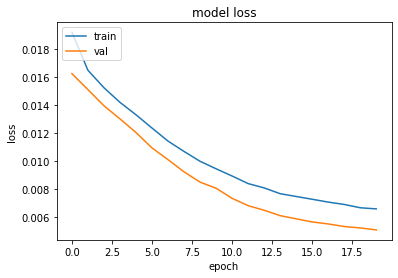

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

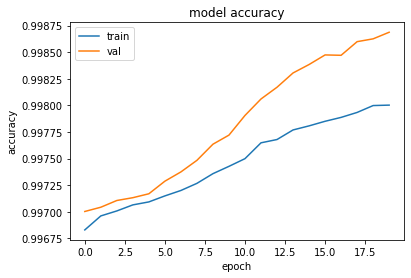

In [97]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [98]:
def metric(y_true, y_pred):
    metrics = []
    for i in range(y_pred.shape[1]):
        if y_true[:, i].sum() > 1:
            metrics.append(log_loss(y_true[:, i], y_pred[:, i].astype(float)))
    return np.mean(metrics)

print(f'OOF Metric: {metric(np.asarray(labels_val), np.asarray(result_prediction))}')

OOF Metric: 0.04364965573791188


In [ ]:
result_prediction2 = model.predict(train_dataset)

In [102]:
labels_val2 = visu_label[:int(dataset_size*0.7)]
labels_val2 = labels_val2.drop(['sig_id'], axis=1)

print(f'OOF Metric: {metric(np.asarray(labels_val2), np.asarray(result_prediction2))}')

OOF Metric: 0.004821599612723515


We can see that with the 20 epochs our model seems to be overfitted. The score with the train_dataset
is much lower than the one with the val_dataset. If we reduce the number of epochs (2) we see the score of prediction on the train dataset increase
(from 0.004 to 0.04) and the score of the prediction on val_dataset decrease (from 0.05 to 0.03)
so this result do better prediction on new data

In [103]:
model2 = tf.keras.Sequential([
    feature_layer,
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    tfa.layers.WeightNormalization(layers.Dense(2048, activation='relu')),
    layers.Dropout(0.4),
    layers.BatchNormalization(),
    tfa.layers.WeightNormalization(layers.Dense(1024, activation='elu')),
    layers.Dropout(0.4),
    layers.BatchNormalization(),
    tfa.layers.WeightNormalization(layers.Dense(206, activation='softmax'))
])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model2.fit(train_dataset,
          validation_data=val_dataset,
          epochs=2)

Epoch 1/2
521/521 [==============================] - 245s 469ms/step - loss: 0.0191 - accuracy: 0.9968 - val_loss: 0.0165 - val_accuracy: 0.9970
Epoch 2/2
521/521 [==============================] - 191s 367ms/step - loss: 0.0166 - accuracy: 0.9969 - val_loss: 0.0153 - val_accuracy: 0.9970


In [106]:
labels_val3 = visu_label[:int(dataset_size*0.7)]
labels_val3 = labels_val3.drop(['sig_id'], axis=1)
result_prediction3 = model2.predict(val_dataset)


print(f'OOF Metric: {metric(np.asarray(labels_val3), np.asarray(result_prediction3))}')

ValueError: Found input variables with inconsistent numbers of samples: [7144, 16669]

In [ ]:
labels_val4 = visu_label[:int(dataset_size*0.7)]
labels_val4 = labels_val4.drop(['sig_id'], axis=1)
result_prediction4 = model2.predict(train_dataset)

print(f'OOF Metric: {metric(np.asarray(labels_val4), np.asarray(result_prediction4))}')